# Video classification with a 3D convolutional neural network (CNN)



In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
#import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from pathlib import Path
from tensorflow.keras.utils import plot_model


2022-12-10 12:30:11.016069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/danield/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-10 12:30:11.016086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and preprocess video data

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [2]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 10):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
# Loading paths to datasets
subset_paths = {
                'train' : Path('/workspaces/final-project-shot-type-main/data/shot-type-dataset/trailer_v1500/train'),
                'val'   : Path('//workspaces/final-project-shot-type-main/data/shot-type-dataset/trailer_v1500/val'),
                'test'  : Path('/workspaces/final-project-shot-type-main/data/shot-type-dataset/trailer_v1500/test_complete/test')
            }

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [4]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training = True),
                                          output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(32)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)
val_ds = val_ds.batch(32)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                         output_signature = output_signature)

test_ds = test_ds.batch(32)

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/final-project-shot-type-main/data/shot-type-dataset/trailer_v1500/train'

## Create the model

The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.


This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.


The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [ ]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model resnet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculatoion, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(4)(x)

model = keras.Model(input, x)

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

In [ ]:
# Visualize the model
plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [ ]:
filepath = "/workspaces/final-project-shot-type-main/experiments/conv_3d/h5s/model.weights_conv_3d_trailer_v1500.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                              patience=7, min_lr=0.000001)

In [ ]:
history = model.fit(x = train_ds,
                    epochs = 75, 
                    validation_data = val_ds,
                    callbacks=[checkpoint])

Epoch 1/75


2022-11-29 05:28:50.558350: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-11-29 05:28:51.127724: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-29 05:28:51.128215: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-29 05:28:51.128257: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-29 05:28:51.128909: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-29 05:28:51.129030: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


    160/Unknown - 2190s 14s/step - loss: 1.3256 - accuracy: 0.3880
Epoch 1: val_loss improved from inf to 1.46981, saving model to /workspaces/final-project-shot-type-main/experiments/conv_3d/h5s/model.weights_conv_3d_trailer_v1500.h5
160/160 [==============================] - 2331s 15s/step - loss: 1.3256 - accuracy: 0.3880 - val_loss: 1.4698 - val_accuracy: 0.2971
Epoch 2/75
160/160 [==============================] - ETA: 0s - loss: 1.2740 - accuracy: 0.4347 
Epoch 2: val_loss did not improve from 1.46981
160/160 [==============================] - 2311s 14s/step - loss: 1.2740 - accuracy: 0.4347 - val_loss: 1.5787 - val_accuracy: 0.2927
Epoch 3/75
160/160 [==============================] - ETA: 0s - loss: 1.2494 - accuracy: 0.4494 
Epoch 3: val_loss improved from 1.46981 to 1.41519, saving model to /workspaces/final-project-shot-type-main/experiments/conv_3d/h5s/model.weights_conv_3d_trailer_v1500.h5
160/160 [==============================] - 2321s 15s/step - loss: 1.2494 - accuracy:

### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

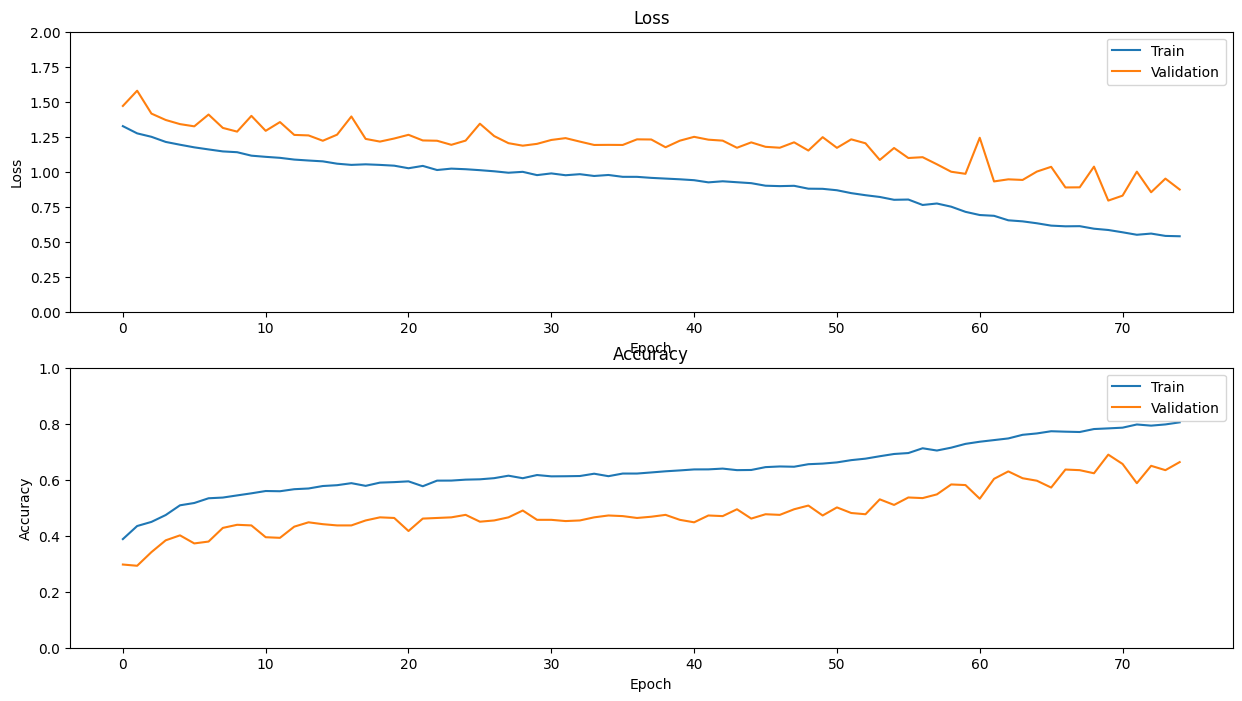

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(15, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [ ]:
model.evaluate(test_ds, return_dict = True)

16/16 [==============================] - 161s 10s/step - loss: 0.9438 - accuracy: 0.6392


{'loss': 0.9437947869300842, 'accuracy': 0.6391752362251282}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [ ]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
labels = ['Motion', 'Pull', 'Push', 'Static']

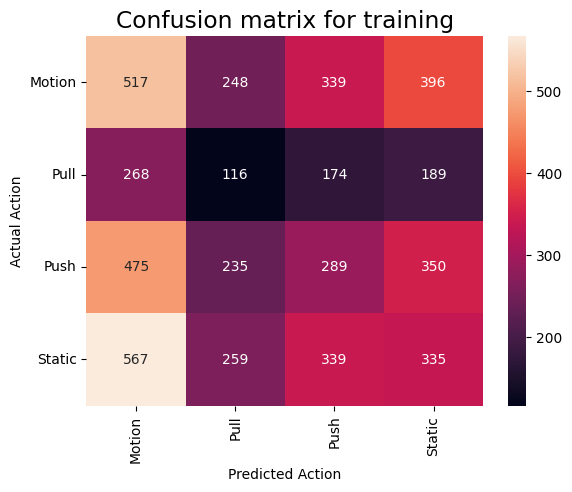

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

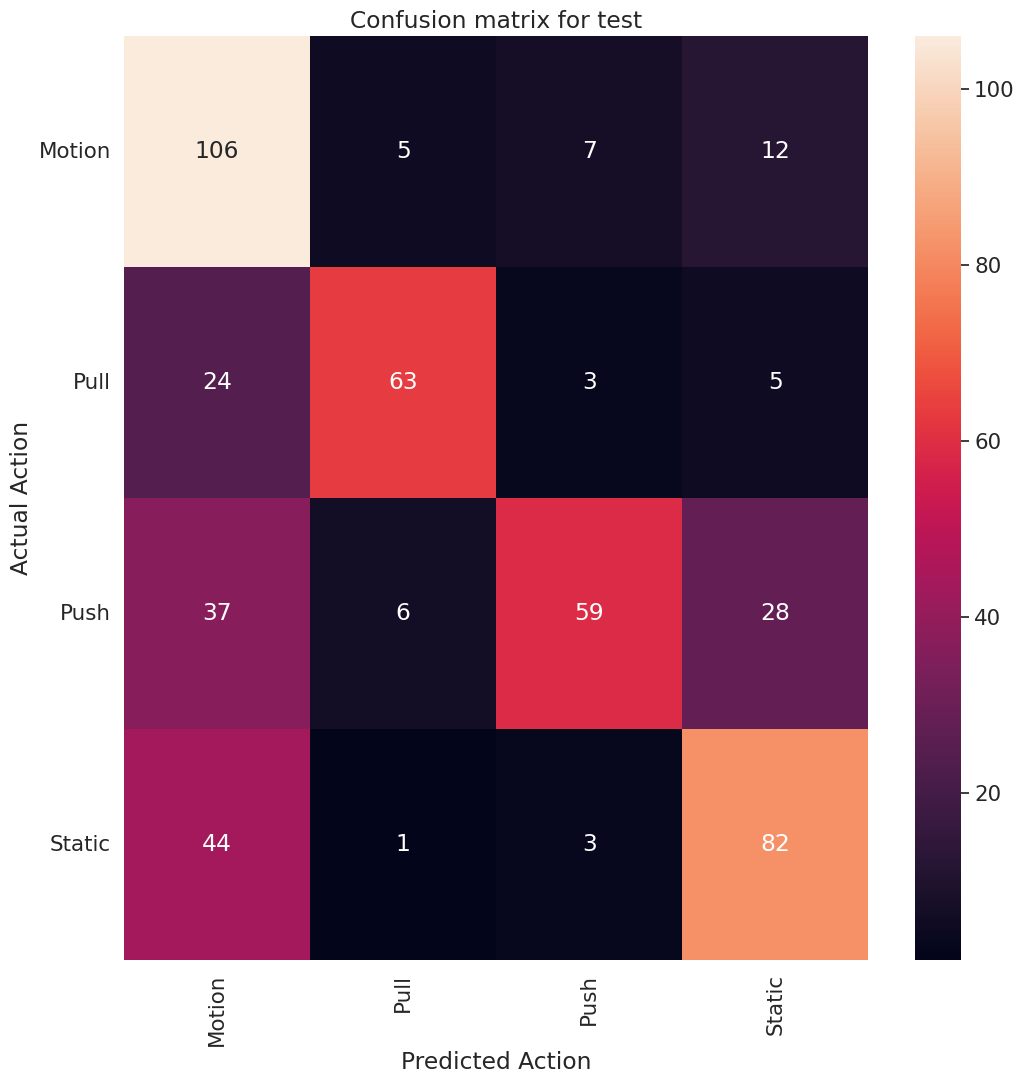

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix. 

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

{'Motion': 0.5023696682464455,
 'Pull': 0.84,
 'Push': 0.8194444444444444,
 'Static': 0.6456692913385826}

In [ ]:
recall

{'Motion': 0.8153846153846154,
 'Pull': 0.6631578947368421,
 'Push': 0.45384615384615384,
 'Static': 0.6307692307692307}

In [ ]:
np.save('/workspaces/final-project-shot-type-main/model/train/train_history_v1500.npy',history.history)

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/workspaces/final-project-shot-type-main/model/train/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

Second training (keep training)

In [ ]:
filepath = "/workspaces/final-project-shot-type-main/experiments/conv_3d/h5s/model.weights_conv_3d_trailer_v1500_ext.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                              patience=7, min_lr=0.000001)

In [ ]:
history2 = model.fit(x = train_ds,
                    epochs = 110, 
                    validation_data = val_ds,
                    callbacks=[checkpoint],
                    initial_epoch=75 )

Epoch 76/110
    160/Unknown - 2264s 14s/step - loss: 0.5172 - accuracy: 0.8087
Epoch 76: val_loss improved from 1.00592 to 0.85872, saving model to /workspaces/final-project-shot-type-main/experiments/conv_3d/h5s/model.weights_conv_3d_trailer_v1500_ext.h5
160/160 [==============================] - 2408s 15s/step - loss: 0.5172 - accuracy: 0.8087 - val_loss: 0.8587 - val_accuracy: 0.6608
Epoch 77/110
160/160 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.8095 
Epoch 77: val_loss did not improve from 0.85872
160/160 [==============================] - 2412s 15s/step - loss: 0.5127 - accuracy: 0.8095 - val_loss: 0.9289 - val_accuracy: 0.6319
Epoch 78/110
160/160 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.8171 
Epoch 78: val_loss improved from 0.85872 to 0.81729, saving model to /workspaces/final-project-shot-type-main/experiments/conv_3d/h5s/model.weights_conv_3d_trailer_v1500_ext.h5
160/160 [==============================] - 2444s 15s

In [ ]:
np.save('/workspaces/final-project-shot-type-main/model/train/train_history2_v1500.npy',history.history)

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = '/workspaces/final-project-shot-type-main/model/train/history2json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
np.save('/workspaces/final-project-shot-type-main/model/train/train_history2_v1500.npy',history2.history)

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history2.history) 

# save to json:  
hist_json_file = '/workspaces/final-project-shot-type-main/model/train/history2json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

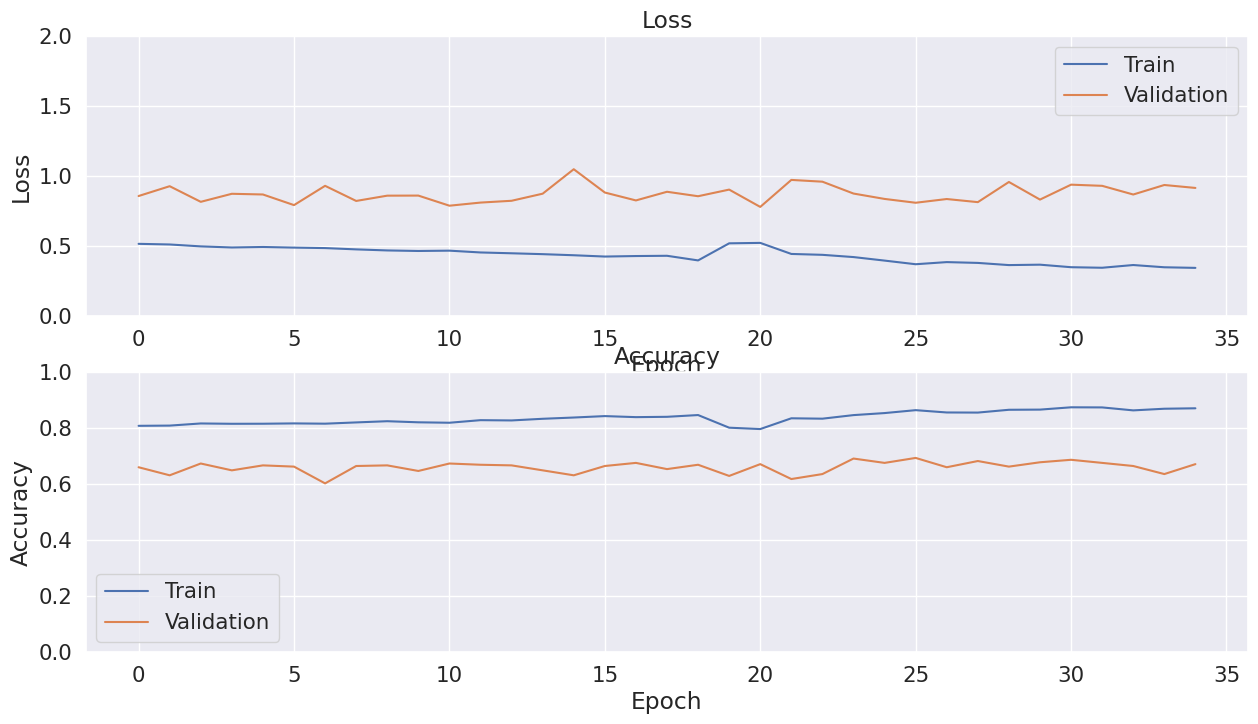

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(15, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history2)

In [ ]:
model.evaluate(test_ds, return_dict = True)

16/16 [==============================] - 166s 10s/step - loss: 0.9137 - accuracy: 0.6784


{'loss': 0.9136548042297363, 'accuracy': 0.6783505082130432}

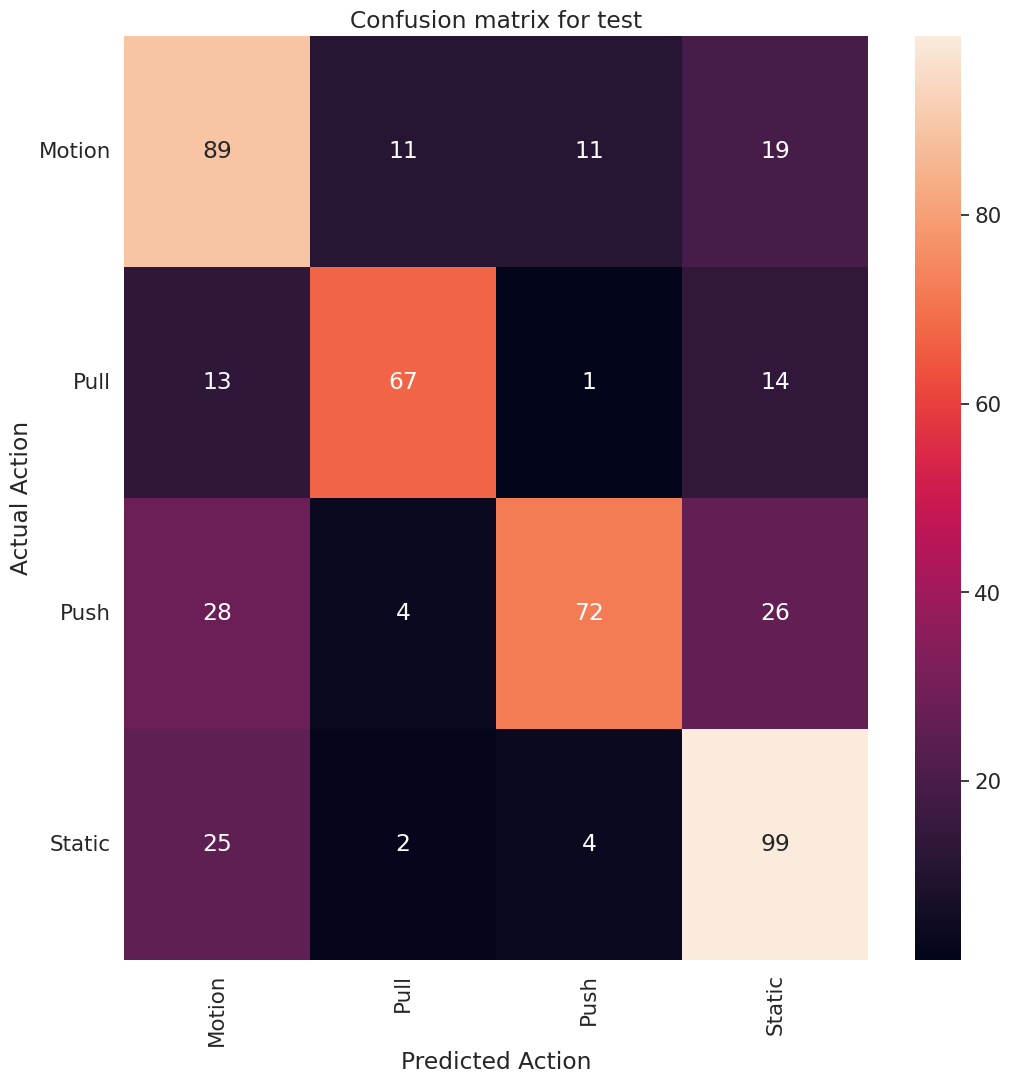

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
from sklearn.metrics import classification_report
y_true = actual
y_pred = predicted
target_names = labels
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Motion       0.57      0.68      0.62       130
        Pull       0.80      0.71      0.75        95
        Push       0.82      0.55      0.66       130
      Static       0.63      0.76      0.69       130

    accuracy                           0.67       485
   macro avg       0.70      0.68      0.68       485
weighted avg       0.70      0.67      0.68       485



Evaluating with the complete dataset (the paper dataset)

In [ ]:
model.load_weights('/workspaces/final-project-shot-type-main/experiments/conv_3d/h5s/model.weights_conv_3d_trailer_v1500.h5')
model.evaluate(test_ds, return_dict = True)

2022-12-06 18:50:02.499372: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1027604480 exceeds 10% of free system memory.
2022-12-06 18:50:12.375162: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1027604480 exceeds 10% of free system memory.
2022-12-06 18:50:15.711175: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1027604480 exceeds 10% of free system memory.


      1/Unknown - 66s 66s/step - loss: 0.7825 - accuracy: 0.5938

2022-12-06 18:51:02.157586: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1027604480 exceeds 10% of free system memory.
2022-12-06 18:51:11.655662: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1027604480 exceeds 10% of free system memory.


255/255 [==============================] - 13211s 52s/step - loss: 0.8055 - accuracy: 0.6811


{'loss': 0.8054829835891724, 'accuracy': 0.6810651421546936}

In [ ]:
model.save('/workspaces/final-project-shot-type-main/model/conv3d/conv3d_model_68percent.h5')

Confusion Matrix for complete test dataset

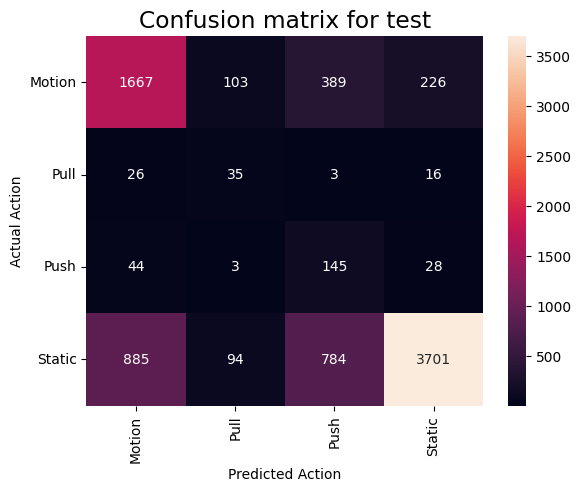

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
from sklearn.metrics import classification_report
y_true = actual
y_pred = predicted
target_names = labels
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Motion       0.64      0.70      0.67      2385
        Pull       0.15      0.44      0.22        80
        Push       0.11      0.66      0.19       220
      Static       0.93      0.68      0.78      5464

    accuracy                           0.68      8149
   macro avg       0.46      0.62      0.47      8149
weighted avg       0.82      0.68      0.73      8149

